In [1]:
import torch

@torch.no_grad()
def time_vel_to_vrms_equal_dt(v_t: torch.Tensor, time_dim: int = 1) -> torch.Tensor:
    """
    等时间步长下的 v(t) -> V_rms(t)
    输入:
        v_t: 速度张量，等间隔采样。典型形状 (1, 1000, 70)，time_dim=1
    返回:
        Vrms: 与 v_t 同形状的 RMS 速度
    公式:
        Vrms^2(t_k) = (1/k) * sum_{i=1..k} v(t_i)^2
    """

    # 按时间维做前缀和
    v2_cum = (v_t ** 2).cumsum(dim=time_dim)

    # 构造步数 k=1..T，并在非时间维做广播
    T = v_t.size(time_dim)
    # 形如 (..., T, ...): 在 time_dim 放入长度 T，其他维为 1 以便广播
    shape = [1] * v_t.ndim
    shape[time_dim] = T
    steps = torch.arange(1, T + 1, dtype=torch.float64, device=v.device).view(*shape)

    vrms2 = (v2_cum / steps).clamp_min(0.0)
    vrms = torch.sqrt(vrms2)
    return vrms

In [1]:
import numpy as np
from matplotlib import pyplot as plt


def save_images(img1, img2, filename='', title1="Ground truth", title2="Reconstructed",
                show=False, save=True, cmap='jet', extent=[0, 700, 700, 0],
                figsize=(10, 5)):
    """
    保存两个灰度图像到文件，并排显示
    :param img1:
    :param img2:
    :param filename: 保存的文件名(带路径)
    :param title1: 图像标题
    :param title2:
    :param show: 是否显示图像
    :param save: 是否保存图像
    :param cmap: 颜色映射，默认为'gray'
    :param figsize: 图像尺寸，元组(宽度, 高度)
    :return:
    """

    fig, axes = plt.subplots(1, 2, figsize=figsize)

    # 显示第一个图像
    im1 = axes[0].imshow(img1, aspect='auto', cmap=cmap, extent=extent)
    axes[0].set_title(title1)
    axes[0].set_xlabel('Length (m)')
    axes[0].set_ylabel('Depth (m)')

    # 显示第二个图像
    im2 = axes[1].imshow(img2, aspect='auto', cmap=cmap, extent=extent)
    axes[1].set_title(title2)
    axes[1].set_xlabel('Length (m)')
    axes[1].set_ylabel('Depth (m)')

    # 添加共享的颜色条
    cbar = fig.colorbar(im1, ax=axes, orientation='vertical')

    # 关键修改：将颜色条刻度从0-1映射到1500-4500
    # 生成原始数据范围的刻度
    original_ticks = np.linspace(0, 1, 5)  # 生成5个均匀分布的刻度
    # 计算对应的目标范围刻度（1500到4500）
    target_ticks = np.linspace(1500, 4500, 5)
    # 设置颜色条的刻度位置和显示标签
    cbar.set_ticks(original_ticks)
    cbar.set_ticklabels([f'{int(t)}' for t in target_ticks])
    cbar.set_label('Velocity (m/s)')  # 设置颜色条的标签
    if save:  # 保存图像
        plt.savefig(filename)

    if show:  # 显示图像(阻塞模式)
        plt.show()

    # 关闭图形以释放内存
    plt.close(fig)

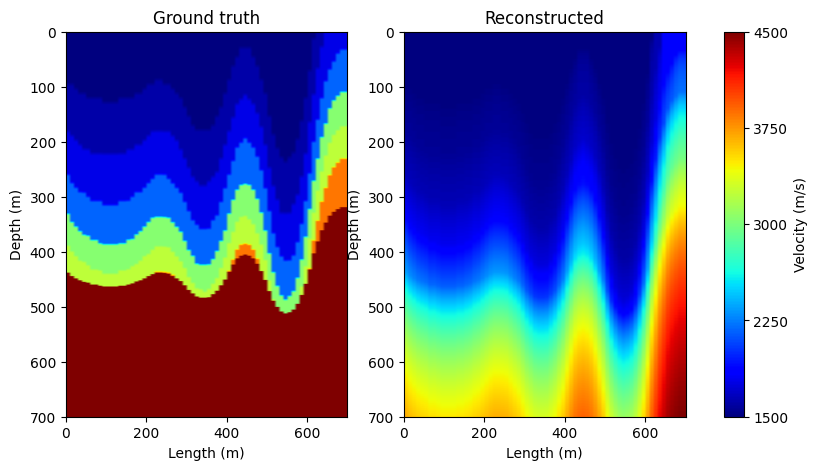

In [8]:
import torch

time_vel = torch.load('openfwi/CurveVelA/test/time_vel/time_vel_120.pt')
rms_vel = time_vel_to_vrms_equal_dt(time_vel * 3000 + 1500)
rms_vel = (rms_vel - 1500) / 3000

save_images(time_vel.numpy().squeeze(), rms_vel.numpy().squeeze(), show=True, save=False, cmap='jet')


In [11]:
import torch
from tqdm import tqdm
import os

for data_set_name in ['FlatVelA', 'FlatVelB','CurveVelA', 'CurveVelB']:
    print(data_set_name)
    for dataset_split in ['train','val', 'test']:
        save_dir = f'openfwi/{data_set_name}/{dataset_split}/rms_vel'
        os.makedirs(save_dir, exist_ok=True)
        if dataset_split == 'train':
            data_num = 21000
        elif dataset_split == 'val':
            data_num = 6000
        else:
            data_num = 3000
        for i in tqdm(range(data_num)):
            rms_vel = time_vel_to_vrms_equal_dt(time_vel * 3000 + 1500)
            rms_vel = (rms_vel - 1500) / 3000
            save_name = os.path.join(save_dir, f'rms_vel_{i}.pt')
            torch.save(rms_vel, save_name)


FlatVelA


100%|██████████| 3000/3000 [00:04<00:00, 699.61it/s]


FlatVelB


100%|██████████| 3000/3000 [00:03<00:00, 753.40it/s]


CurveVelA


100%|██████████| 3000/3000 [00:03<00:00, 755.94it/s]


CurveVelB


100%|██████████| 3000/3000 [00:04<00:00, 687.57it/s]


In [17]:
def save_single_image(img, filename='', title="Image",
                     show=False, save=True, cmap='jet', extent=[0, 700, 700, 0],
                     figsize=(5, 5)):
    """
    保存单个灰度图像到文件
    :param img: 要显示的图像
    :param filename: 保存的文件名(带路径)
    :param title: 图像标题
    :param show: 是否显示图像
    :param save: 是否保存图像
    :param cmap: 颜色映射，默认为'jet'
    :param extent: 图像显示范围
    :param figsize: 图像尺寸，元组(宽度, 高度)
    :return:
    """

    fig, ax = plt.subplots(1, 1, figsize=figsize)

    # 显示图像
    im = ax.imshow(img, aspect='auto', cmap=cmap, extent=extent)
    ax.set_title(title)
    ax.set_xlabel('Length (m)')
    ax.set_ylabel('Depth (m)')

    # 添加颜色条
    cbar = fig.colorbar(im, ax=ax, orientation='vertical')

    # 设置颜色条刻度
    original_ticks = np.linspace(0, 1, 5)  # 生成5个均匀分布的刻度
    target_ticks = np.linspace(1500, 4500, 5)
    cbar.set_ticks(original_ticks)
    cbar.set_ticklabels([f'{int(t)}' for t in target_ticks])
    cbar.set_label('Velocity (m/s)')  # 设置颜色条的标签

    if save:  # 保存图像
        plt.savefig(filename)

    if show:  # 显示图像(阻塞模式)
        plt.show()

    # 关闭图形以释放内存
    plt.close(fig)


In [10]:
import torch

time_vel = torch.load('openfwi/CurveVelA/test/time_vel/time_vel_100.pt').squeeze()
depth_vel = torch.load('openfwi/CurveVelA/test/model/model_100.pt').squeeze()
image = torch.load('openfwi/CurveVelA/test/migrate/migrate_100.pt').squeeze()
horizens = torch.load('openfwi/CurveVelA/test/horizens/horizens_100.pt').squeeze()


# save_single_image(horizens, filename='', title="Horizon",
#                      show=True, save=False, cmap='grey', extent=[0, 700, 700, 0],
#                      figsize=(6, 5))

In [11]:
depth_vel = depth_vel * 3000 + 1500
def save_multiple_curves(curves, labels=None, filename='', title="Multiple Curves",
                        x_label="Depth (m)", y_label="Velocity (m/s)",
                        show=True, save=False, figsize=(10, 6),
                        colors=None, linestyles=None):
    """
    在同一图表中可视化多条曲线

    参数:
    curves : list of arrays
        要绘制的曲线数据列表，每个元素是一条曲线的y值
    labels : list of str, optional
        每条曲线的标签，用于图例显示
    filename : str
        保存图像的文件名(带路径)
    title : str
        图表标题
    x_label : str
        x轴标签
    y_label : str
        y轴标签
    show : bool
        是否显示图像
    save : bool
        是否保存图像
    figsize : tuple
        图像尺寸 (宽度, 高度)
    colors : list of str, optional
        每条曲线的颜色
    linestyles : list of str, optional
        每条曲线的线型

    返回:
    None
    """

    fig, ax = plt.subplots(1, 1, figsize=figsize)

    # 如果没有提供标签，则生成默认标签
    if labels is None:
        # labels = [f'Well log {i+1}' for i in range(len(curves))]
        labels = ['Well log']

    # 如果没有提供颜色，则使用默认颜色循环
    if colors is None:
        colors = [None] * len(curves)

    # 如果没有提供线型，则使用默认线型
    if linestyles is None:
        linestyles = ['-'] * len(curves)

    # 绘制每条曲线
    for i, (curve, label, color, linestyle) in enumerate(zip(curves, labels, colors, linestyles)):
        x_values = range(0, len(curve)*10, 10)  # 自动生成x值
        ax.plot(x_values, curve, label=label, color=color, linestyle=linestyle, linewidth=2)

    # 设置图表属性
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.legend()
    ax.grid(True, alpha=0.3)

    # 保存图像
    if save:
        plt.savefig(filename, dpi=300, bbox_inches='tight')

    # 显示图像
    if show:
        plt.show()

    # 关闭图形以释放内存
    plt.close(fig)


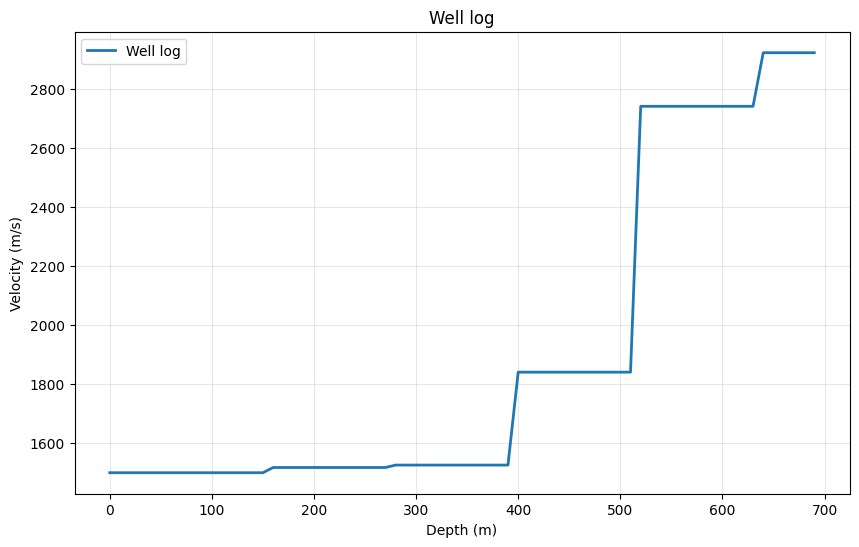

In [13]:
import matplotlib.pyplot as plt
curves = [depth_vel[:, 11]]
save_multiple_curves(curves, labels=None, filename='', title="Well log",
                        x_label="Depth (m)", y_label="Velocity (m/s)",
                        show=True, save=False, figsize=(10, 6),
                        colors=None, linestyles=None)